In [25]:
import matplotlib.pyplot as plt
import stompy.model.delft.dflow_model as dfm
import stompy.model.hydro_model as hm
import xarray as xr
from stompy import utils
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib notebook

In [2]:
import sfb_csc
Model=sfb_csc.SfbCsc

DFM_ROOT NOT SET


In [3]:
runs=[
    dict(run_dir="data_3d_2019_summer-v007",
         label="3D")
     ]

runs=pd.DataFrame(runs)

In [4]:
runs['model'] = runs['run_dir'].apply(lambda r: Model.load(r))

132935 nodes will get default of 0.02


In [5]:
# Dev for stage comparisons
his_ds=runs.loc[0,'model'].his_dataset()


In [6]:
his_ds.stations # 51 stations.

<xarray.DataArray 'stations' (stations: 51)>
array(['HS1', 'DOP', 'CCS', 'SG1', 'LN2', 'HAAS', 'SOI', 'SXS', 'RYI', 'HBW',
       'SSS', 'SUT', 'GES', 'DWS', 'LIB', 'LIS', 'FPX', 'SRV', 'LSHB', 'CCS1',
       'CCEH', 'BSPP', 'CCSC', 'WildlandsUpMarsh_stage', 'DLC', 'GSS', 'SDC',
       'SDI', 'TSL', 'CourtlandToe', 'LIY', 'ToeAtLiberty', 'HollandNBreach',
       'LibertyIslandCut', 'LibCutHolland', 'MIR', 'node320-drain',
       'node320-div', 'HST', 'DWSCTL', 'mdot_CC2', 'mdot_LN1', 'mdot_CA3',
       'mdot_HS1', 'mdot_BK1', 'mdot_CC1', 'mdot_BK2', 'mdot_CAUL', 'mdot_UL1',
       'mdot_CA1', 'mdot_HS2'], dtype='<U22')
Coordinates:
    station_x_coordinate  (stations) float64 ...
    station_y_coordinate  (stations) float64 ...
    station_name          (stations) |S256 b'HS1                                                                                                                                                                                                                      

In [7]:
# Define observations. Use the same classes as for BCs
# since they already have the relevant dynamic loading
#observations={
#    'SRV':dict(stage=hm.NwisStageBC(11455420,name='SRV'),
#               flow=hm.NwisFlowBC(11455420,name='SRV'))
#}

INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


<IPython.core.display.Javascript object>


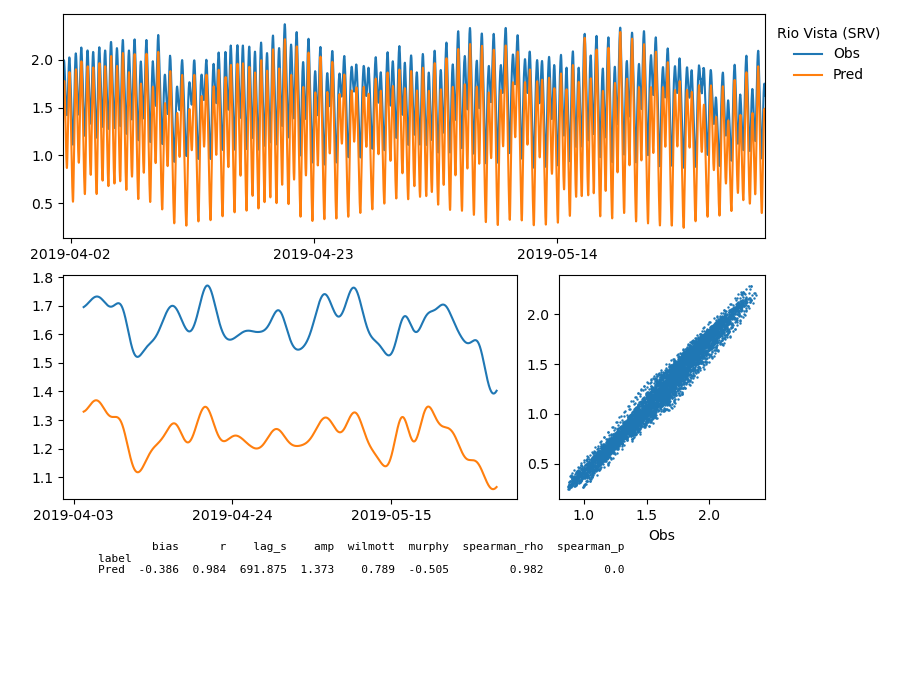

In [32]:
import stompy.model.data_comparison as dc

class ModelData: pass

class DFMStage(ModelData):
    station=None
    data_start=None # will be set from model
    data_stop =None
    
    def __init__(self,model,station):
        self.model=model
        self.station=station
        # Might transition this to better caching at some point.
        self.his=self.model.his_dataset()
        self.data_start=self.his.time.values[0]
        self.data_stop =self.his.time.values[-1]
        #self.data_start=self.model.run_start
        #self.data_stop =self.model.run_stop
        
    def src_data(self):
        da=self.his.sel(stations=self.station)['waterlevel']
        da=da.assign_coords(label='Pred')
        return da 
        
class StageCompare:
    name=None
    pred=None # for stage, name of stations in DFM output
    obs=None  # will look for observations[obs]['stage']
    def __init__(self,sources,**kw):
        self.sources=sources
        utils.set_keywords(self,kw)
        
        if self.name is None:
            self.name=self.sources[0].name    
        
    def assemble_data(self):
        # See which sources already have a date range.
        # choose the final date range based on those.
        starts=[]
        stops =[]
        for source in self.sources:
            if source.data_start is not None:
                starts.append(source.data_start)
            if source.data_stop is not None:
                stops.append(source.data_stop)
        # will need better logic than this. Maybe test for model vs obs.
        start=min(starts)
        stop =max(stops)
        print(f"Inferred time period: {start} to {stop}")
        
        self.data=[]
        
        labels={}
        for src_i,source in enumerate(self.sources):
            if source.data_start is None:
                source.data_start=start
            if source.data_stop is None:
                source.data_stop =stop
            da=source.src_data()
            if 'label' not in da.coords:
                if isinstance(source,hm.BC):
                    label="Obs"
                elif isinstance(source,ModelData):
                    label="Pred"
            else:
                label=da.label.item()
                
            if label in labels:
                label=label+str(src_i)
            labels[label]=True
            self.data.append(da.assign_coords(label=label))
          
    def figure(self):
        self.assemble_data()
        self.combined=dc.combine_sources(self.data)
        fig=dc.calibration_figure_3panel(all_sources=self.data,
                                         combined=self.combined)
        fig.axes[0].legend(title=self.name,loc='upper left',bbox_to_anchor=(1,1),
                           frameon=0)
        fig.subplots_adjust(right=0.85,left=0.07,top=0.98,bottom=0.1)
        return fig
    
hm.NwisStageBC.cache_dir="cache"

# maybe a more generic way
comparisons=[
    StageCompare( [ hm.NwisStageBC(11455420,name='SRV') ]
                 + [DFMStage(model,'SRV') for model in runs['model']],
                 name="Rio Vista (SRV)")
    
    #StageCompare( [ hm.NOAAStageBC(9414750,name='Alameda') ]
    #             + [DFMStage(model,'Alameda') for model in runs['model']],
    #             name="Alameda")
]

for comp in comparisons:
    comp.figure()

In [29]:
# HERE
# Get a list of NOAA stations maybe from an old sfbay run
# Need much better coverage of the Bay to understand where
# it's going wrong in the Delta.

AttributeError: 'DFMStage' object has no attribute 'name'

In [11]:
# Start with Rio Vista
# HERE
comparisons=[
    # it should be relatively painless to compare two stations
    # from one model against another model or observation.
    StageCompare(runs=runs,pred='SRV',obs='SRV')
]

for comp in comparisons:
    comp.figure()

<xarray.DataArray 'stations' (stations: 51)>
array(['HS1', 'DOP', 'CCS', 'SG1', 'LN2', 'HAAS', 'SOI', 'SXS', 'RYI', 'HBW',
       'SSS', 'SUT', 'GES', 'DWS', 'LIB', 'LIS', 'FPX', 'SRV', 'LSHB', 'CCS1',
       'CCEH', 'BSPP', 'CCSC', 'WildlandsUpMarsh_stage', 'DLC', 'GSS', 'SDC',
       'SDI', 'TSL', 'CourtlandToe', 'LIY', 'ToeAtLiberty', 'HollandNBreach',
       'LibertyIslandCut', 'LibCutHolland', 'MIR', 'node320-drain',
       'node320-div', 'HST', 'DWSCTL', 'mdot_CC2', 'mdot_LN1', 'mdot_CA3',
       'mdot_HS1', 'mdot_BK1', 'mdot_CC1', 'mdot_BK2', 'mdot_CAUL', 'mdot_UL1',
       'mdot_CA1', 'mdot_HS2'], dtype='<U22')
Coordinates:
    station_x_coordinate  (stations) float64 ...
    station_y_coordinate  (stations) float64 ...
    station_name          (stations) |S256 b'HS1                                                                                                                                                                                                                      